In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dataset=pd.read_csv("Churn_Modelling.csv")
dataset.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
dataset.shape

(10000, 14)

In [4]:
dataset.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [5]:
X=dataset.iloc[:,3:13]
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [6]:
Y=dataset.iloc[:,13]
Y.head()

0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

In [7]:
X.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
dtype: object

In [8]:
X['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [9]:
X['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

# Create dummy variables

In [10]:
geography=pd.get_dummies(X['Geography'],drop_first=True)
gender=pd.get_dummies(X['Gender'],drop_first=True)

In [11]:
X=pd.concat([X,geography,gender],axis=1)
X=X.drop(['Geography','Gender'],axis=1)
X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Germany,Spain,Male
0,619,42,2,0.00,1,1,1,101348.88,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,1,0


In [12]:
X.shape

(10000, 11)

In [13]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,Y,random_state=0,test_size=0.2)

In [14]:
from xgboost import XGBClassifier
xg_boost=XGBClassifier().fit(X_train,y_train)

c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [15]:
import lime
from lime import lime_tabular
interpret=lime_tabular.LimeTabularExplainer(training_data=np.array(X_train),
                                            feature_names=X_train.columns,mode='classification')

In [16]:
exp=interpret.explain_instance(data_row=X_test.iloc[2],predict_fn=xg_boost.predict_proba)
exp.show_in_notebook(show_table=True)

In [17]:
import eli5
from eli5.sklearn import PermutationImportance
imp=PermutationImportance(xg_boost,random_state=1).fit(X_test,y_test)
eli5.show_weights(imp,feature_names=X_test.columns.to_list())

Using TensorFlow backend.


Weight,Feature
0.0656 ± 0.0112,Age
0.0557 ± 0.0072,NumOfProducts
0.0211 ± 0.0037,IsActiveMember
0.0185 ± 0.0033,Balance
0.0127 ± 0.0095,Germany
0.0028 ± 0.0029,Male
0.0005 ± 0.0026,Spain
0.0004 ± 0.0028,HasCrCard
0.0000 ± 0.0125,EstimatedSalary
-0.0008 ± 0.0026,Tenure


So, "Age" and "NumOfProducts" are the two top most beneficial festures.

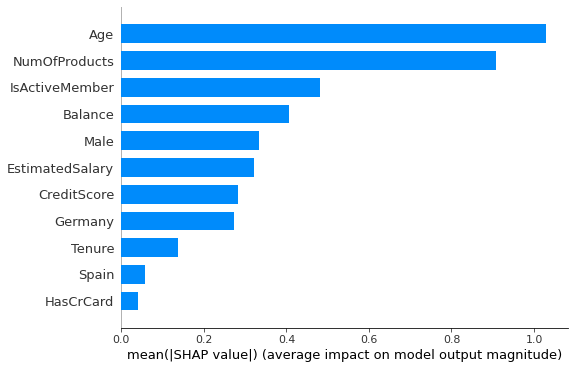

In [18]:
import shap
explain=shap.Explainer(xg_boost)
shap_value=explain.shap_values(X_test)
shap.summary_plot(shap_value,X_test,plot_type='bar')

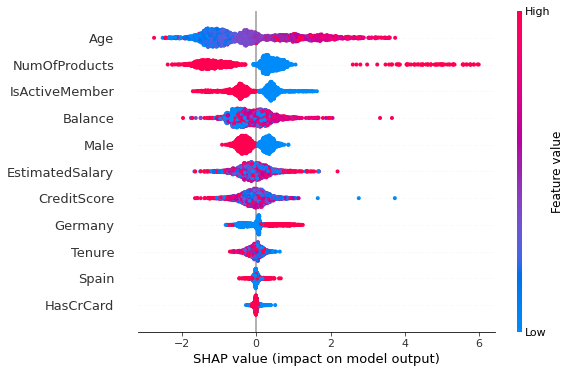

In [19]:
shap.summary_plot(shap_value,X_test)

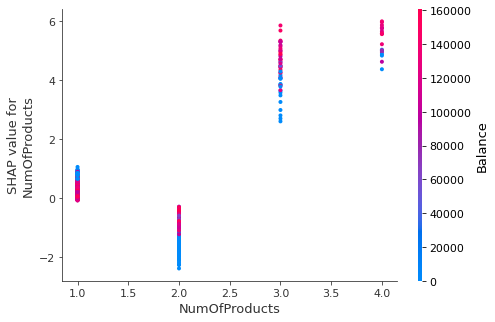

In [22]:
shap.dependence_plot(ind='NumOfProducts',interaction_index='Balance',
                     shap_values=shap_value,features=X_test)

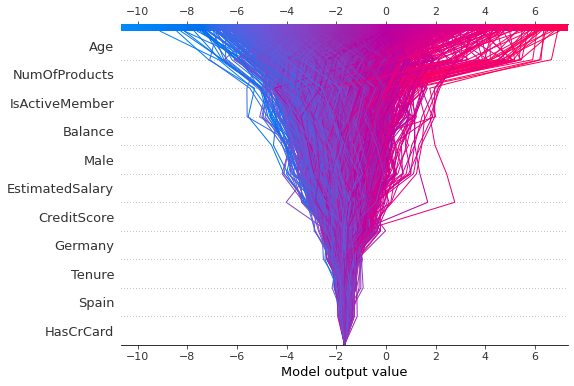

In [25]:
expected_value=explain.expected_value
shap.decision_plot(expected_value,shap_value,features=X_test)